In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.integrate import nquad
from scipy.special import ellipe
from scipy.special import ellipk
from scipy.interpolate import lagrange
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import savgol_filter

## User input

In [2]:
user = True  # use imported data

# Gas:
raddens = "../data/gasmsd_kpc_linear.txt"      # Gas density with 2 columns, units: KPC, MSUN/PC^2
units = 'KPC,MSUN/PC**2'
radii = np.arange(0.001,11,0.01)

# Disk:
#raddens = "../data/NGC5005-disk_arcsec.txt"    # Disk surface brightness with 4 colums, units: ARCSEC, MAG/ARCSEC^2
#units = 'ARCSEC,MAG/ARCSEC**2'
#radii = np.arange(0.001,35,0.01)

zlaw = 2                            # Case 2: sech-squared density law
mode = zlaw                         # Density distribution mode

# Parameters
G = 0.00000431158                   # Gravitational constant (KPC/MSUN*(KM/S)^2)  
#CONSTANT = 2.0 * np.pi * G / 3.0
EPS = 1
z0 = 0.93
distance = 16.5                    # Distance in MPC

# we only need dens0 and h if user is FALSE (i.e. when density is calculated), otherwise we don't need it
h = 10.0                           # GUESS: radial scale-length (KPC)
dens0 = 10**2.4                    # GUESS: central surface density (MSUN/PC^2): from Fig 8. Paper 13

## Density profile

In [3]:
def DensityProfile(user=user,raddens=raddens,units=units,mode=mode,dens0=dens0,h=h):
    
    ##################################
    # Case 1: Import density profile #
    ##################################
    
    if user == True:
        if units == 'KPC,MSUN/PC**2':
            mudata = np.loadtxt(raddens)
            if np.shape(np.loadtxt(raddens))[1] == 2:     # this just checks if the file has 2 or 4 columns
                xdinp, ydinp = mudata.T
            if np.shape(np.loadtxt(raddens))[1] == 4:
                xdinp, ydinp, xerror, yerror = mudata.T

        if units == 'ARCSEC,MAG/ARCSEC**2':
            mudata = np.loadtxt(raddens)
            if np.shape(np.loadtxt(raddens))[1] == 2:
                xdinp, ydinp = mudata.T
            if np.shape(np.loadtxt(raddens))[1] == 4:
                xdinp, ydinp, xerror, yerror = mudata.T

            # Conversion
            # ARCSEC to KPC
            xdinp = 4.8481E-3 * distance * xdinp

            # MAG/ARCSEC^2 to MSUN/PC^2
            ydinp = 10**(-0.4 * ydinp)
            ydinp = (4.8481E-3 * distance)**(-2) * ydinp
            
        if units == 'KPC,MAG/ARCSEC**2':
            mudata = np.loadtxt(raddens)
            if np.shape(np.loadtxt(raddens))[1] == 2:
                xdinp, ydinp = mudata.T
            if np.shape(np.loadtxt(raddens))[1] == 4:
                xdinp, ydinp, xerror, yerror = mudata.T

            # Conversion
            # MAG/ARCSEC^2 to MSUN/PC^2
            ydinp = 10**(-0.4 * ydinp)
            ydinp = (4.8481E-3 * distance)**(-2) * ydinp
            
        LEN1 = len(xdinp)                   # GUESS: defined as length of radius array
        LEN2 = len(ydinp)                   # GUESS: defined as lenght of density array
        ndinp = LEN2                        # number of surface densities. GUESS: length of density array again
        rcut = xdinp[ndinp-1]               # takes second to last radius value
        delta = rcut - xdinp[ndinp-2]       # difference between the second to last radius value and the third to last radius value
    
    
    #####################################
    # Case 2: Calculate density profile #
    #####################################
    
    if user == False:
    
        # User need to provide dens0 (in MSUN/PC^2) and h (in KPC)
        dens0 = dens0           # central density of exponential DISK
        # convert disk central surface brightness from MAG/ARCSEC^2 to MSUN/KPC^2
        #dens0 = 10**(-0.4 * dens0)       
        #dens0 = (4.8481E-3 * distance)**(-2) * dens0
        #dens0 = dens0 * 1.0e6        
        #print("dens0 = {:.4}".format(dens0))

        h = h                   # radial scale length
        z0 = 0.2*h              # scale height of DISK in kpc [0.0]. 
                                  # note: The integration in Z is the most time consuming part
                                  # of the calculation. For example it takes about 0.2 seconds
                                  # to calculate a point on the rotation curve for a disk with zero
                                  # thickness, and about 2 seconds for a disk with non-zero thickness.
        rcut = 4*h              # cutoff radius
        delta = 0.2*h           # softening parameter of DISK in kpc [0.0]. It may be wise
                                  # to have a non-zero softening in case of a truncated disk, 
                                  # because then the sharp features in the calculated rotation 
                                  # curve will be smoothed out. A softening parameter of about 
                                  # 0.2 scale lengths would be sufficient.

        # Now calculate the surface densities
        LEN1 = 100
        LEN2 = 100
        xdinp = np.zeros(LEN2-1)    # radii surface density
        ydinp = np.zeros(LEN2-1)    # surface densities
        rdinp = rcut + delta      # max radius, where galaxy ends
        ndinp = LEN2 - 1          # number of surface densities
        xstep = rdinp / (ndinp - 1)        # step in radius

        i = 0                              # counter 
        while i < ndinp:
            # Casertano's piecewise function (Eq.3)
            xdinp[i] = x = xstep * i
            if x >= rcut and delta > 0.0:
                y = dens0 * np.exp(-rcut/h)*(rcut+delta-x)/delta
            elif x >= rdinp:
                y = 0.0                    # end of disk
            else:
                y = dens0 * np.exp(-x/h)
            ydinp[i] = y
            i += 1
    return xdinp, ydinp, ndinp, rcut, delta, LEN1, LEN2

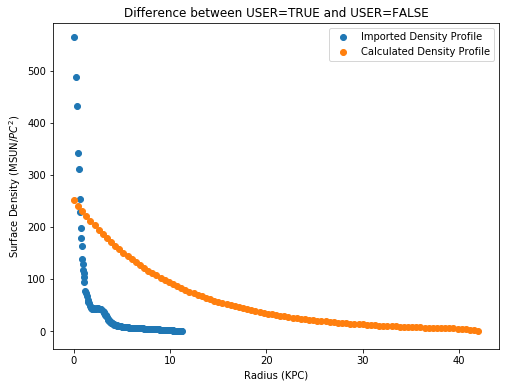

In [4]:
# Plot 
plt.figure(figsize=(8,6))
xdinp_imported = DensityProfile(user=True)[0]
ydinp_imported = DensityProfile(user=True)[1]
plt.scatter(xdinp_imported,ydinp_imported, label="Imported Density Profile")

xdinp_calculated = DensityProfile(user=False)[0]
ydinp_calculated = DensityProfile(user=False)[1]
plt.scatter(xdinp_calculated,ydinp_calculated, label="Calculated Density Profile")
plt.xlabel("Radius (KPC)")
plt.ylabel("Surface Density (MSUN/$PC^2$)")
plt.title("Difference between USER=TRUE and USER=FALSE")
plt.legend()
plt.show()

## Define some values

In [5]:
# Radius
xdinp = DensityProfile()[0]
# Density
ydinp = DensityProfile()[1]

# Cutoff radius
rcut = DensityProfile()[3]
# Cutoff length
delta = DensityProfile()[4]

## Density distribution

In [6]:
# There are three distribution laws possible; 
# the Van der Kruit and Searle law (SECH-SQUARED): D(Z)=sech(Z/Z0)**2/Z0,
# an exponential density law (EXPONENTIAL): D(Z)=exp(-Z/Z0)/Z0 
# a simple sech law (SIMPLE-SECH): D(Z)=2*sech(Z/Z0)/Z0/PI. 

# case 1 is a flat disk, z0 = 0
#####################################

# Sech-squared law:
def denzed_case2(z,z0): 
    r = np.cosh(z / z0)
    #r = r * r * z0    # In the GIPSY rotmod.c, this is multiplied by z0 but in Caserano Eq 2 there isn't any z0
    r = r * r
    r = 1.0 / r
    return r

# Exponential:
def denzed_case3(z,z0):
    r = np.exp(-z / z0) /z0
    return r

# Simple-sech
def denzed_case4(z,z0):
    r = 2 / z0 / np.pi / np.cosh(z/z0)
    return r

def denzed(z,z0,mode):
    #The above results in the user being asked for every point entered; this was likely used as a backend.
    if mode == 2:
        return denzed_case2(z,z0)
    if mode == 3:
        return denzed_case2(z,z0)
    if mode == 4:
        return denzed_case4(z,z0)
    else:
        return np.nan
        print("Error occured in denzed; no mode selected. Returned nan.")

## Interpolation

In [7]:
def interpd(x,y):
    #return lagrange(x,y)                # Lagrange interpolation didn't work well so I used Univariate Spline
    return InterpolatedUnivariateSpline(x,y,k=4)

# Calculate the density values at the sampling radii, using Lagrange Interpolation
polynomial = interpd(xdinp,ydinp)        # define the polynomial that's calculated, type: numpy.poly1d
densit = polynomial(radii)               # evaluate values at the sampling radii, just for plotting

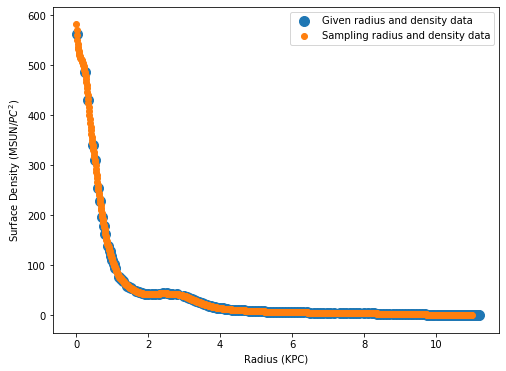

In [8]:
# Plot 
plt.figure(figsize=(8,6))
plt.scatter(xdinp,ydinp, label="Given radius and density data", s=100)
plt.scatter(radii,densit, label="Sampling radius and density data")
plt.xlabel("Radius (KPC)")
plt.ylabel("Surface Density (MSUN/$PC^2$)")
plt.legend()
plt.show()

## Partial derivative

In [9]:
# Partial derivative of rho(u,z) with respect to u - originally
# This takes the derivative of the splined polynomial
densitderivative = polynomial.derivative()

# Evaluate at given radii. Note: we won't need this defined explicitly, just for the plot below
drho_du_values = densitderivative(radii)

## Smoothing

In [10]:
# Savitzky-Golay filter: https://riptutorial.com/scipy/example/15878/using-a-savitzky-golay-filter
drho_du_smooth = savgol_filter(drho_du_values, 81, 3)  # window size (how many points to ) 81, polynomial order 3

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


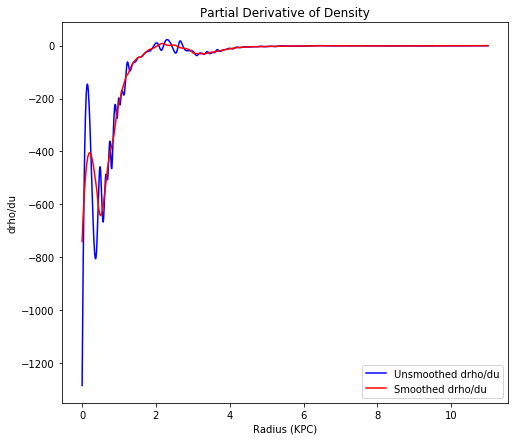

In [11]:
# Plot 
plt.figure(figsize=(8,7))
plt.plot(radii,drho_du_values, label="Unsmoothed drho/du", c="blue")
plt.plot(radii,drho_du_smooth, label="Smoothed drho/du", c="red")
plt.title("Partial Derivative of Density")
plt.xlabel("Radius (KPC)")
plt.ylabel("drho/du")
plt.legend()
plt.show()

## Functions

In [12]:
# Casertano Eq 2
def drho_du(r,z,z0,mode):
    return densitderivative(r) * denzed(z,z0,mode)
# In Casertano's eq 2, the cosh term is multiplied by rho0(r)
# I multiplied it with the calculated derivative of the density 
# so I think this should result in drho/du

In [13]:
# Casertano Eq 5
def px(r,u,z):
    x = (r**2 + u**2 + z**2)/(2*r*u)
    return x - (np.sqrt((x**2)-1))

In [14]:
# Complete elliptic integral
def K(r,u,z):
    return ellipk(px(r,u,z)) - ellipe(px(r,u,z))

In [15]:
# Inner function
def innerfunc(r,u,z,z0,mode):
    return ((4 * np.pi * G) * drho_du(r,z,z0,mode) * K(r,u,z) * 2 * np.sqrt(u)) / (np.pi * np.sqrt(r * px(r,u,z)))

## Integration

In [16]:
# Define minimum and maximum values of radius for integration
intmin = np.min(radii)
intmax = np.max(radii)

In [17]:
# Reverse order of variables to setup for integration
innerfunc2 = lambda z,u,r,z0,mode: innerfunc(r,u,z,z0,mode)

# Integrate
radialforce = lambda r,z0,mode: nquad(innerfunc2, [[intmin,intmax], [intmin,intmax]], args=(r,z0,mode))[0]

## Velocity

In [18]:
radialforce = np.vectorize(radialforce)
velocs = np.sqrt(-radii*radialforce(radii,z0,mode))

velocs_smooth = savgol_filter(velocs, 81, 3)

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


## Comparison

In [19]:
# Gas
tracedgas = np.loadtxt("../NGC_5005/traced_data/ngc5005_gas.txt")
tracedgas_r, tracedgas_v = tracedgas.T
tracedgas_r = tracedgas_r[1:]
tracedgas_v = tracedgas_v[1:]

# Disk
traceddisk = np.loadtxt("../NGC_5005/traced_data/ngc5005_disk.txt")
traceddisk_r, traceddisk_v = traceddisk.T
traceddisk_r = traceddisk_r[1:]
traceddisk_v = traceddisk_v[1:]

## Plot

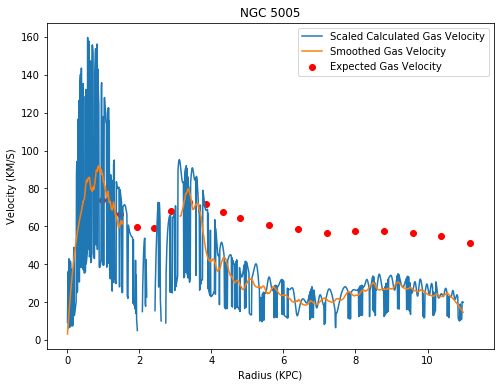

In [20]:
plt.figure(figsize=(8,6))             
plt.plot(radii, 500*velocs, linestyle='solid', label='Scaled Calculated Gas Velocity')
plt.plot(radii, 500*velocs_smooth, linestyle='solid', label='Smoothed Gas Velocity')
plt.scatter(tracedgas_r, tracedgas_v, label='Expected Gas Velocity', c='red')
plt.axis('tight');
plt.title('NGC 5005')
plt.xlabel('Radius (KPC)', fontsize=10)
plt.ylabel('Velocity (KM/S)', fontsize=10)
#plt.xlim(0,12)
plt.legend(fontsize=10)
plt.show()

In [21]:
print(radii)
print(velocs)

[1.0000e-03 1.1000e-02 2.1000e-02 ... 1.0971e+01 1.0981e+01 1.0991e+01]
[0.01831444 0.05645902 0.07225512 ... 0.03980712 0.03950708 0.03960209]
